In [59]:
import aipy
import glob
import healpy as hp
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import os
from pygdsm import GlobalSkyModel
from scipy.interpolate import RectBivariateSpline, interp1d
import uvtools

## Load 21cm models

In [60]:
def z_to_nu(z):
    nu_0 = 1420405751.768  # Hz
    return nu_0 / (z+1)

redshifts = np.loadtxt('z_EIGSEP.txt')
freqs_models = z_to_nu(redshifts) / 1e9  # GHz
models = np.loadtxt('T21_EIGSEP.txt') / 1e3  # mK to K

freqs_models = freqs_models[::-1]
models = models[:, ::-1]

## Import Beams

In [61]:
# each file is the beam at a unique frequency

vivaldi_path = 'beams/vivaldi_beams/'
beamfiles = sorted(glob.glob(vivaldi_path + '*.txt'))
beamfiles = beamfiles[-50:] + beamfiles[:-50]  # sort files in order of increasing frequency
beamfiles = beamfiles[:-1]

dish_path = 'beams/dish_beams/'
beamfiles_dish = sorted(glob.glob(dish_path + '*.txt'))
beamfiles_dish = beamfiles_dish[-50:] + beamfiles_dish[:-50]
beamfiles_dish = beamfiles_dish[:-1]

### Vivaldi Beam

In [62]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs_beam = np.array([float(f.split()[1][3:-1]) for f in beamfiles]) / 1000  # get the frequency from the fname, conver to GHz
thetas, phis = np.loadtxt(beamfiles[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas = np.deg2rad(np.unique(thetas))
phis = np.deg2rad(np.unique(phis))
data = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles])
data.shape = (-1, phis.size, thetas.size)

In [63]:
# sample L and M evenly from -1 to 1 and convert to phi and theta
NPIX = 129
L = np.linspace(-1, 1, NPIX,endpoint=True)  # cos(theta)
M = np.linspace(-1, 1, NPIX,endpoint=True)  # sin(theta) sin(phi)
L.shape = (-1, 1)
M.shape = ( 1,-1)
L = L * np.ones_like(M)
M = M * np.ones_like(L)
LM = L**2 + M**2  # cos^2(t) + sin^2(t) sin^2(p) = 1 - sin^2(t) cos^2(p)
N = np.where(LM < 1, np.sqrt(1 - LM), 0)  # sin(theta) cos(phi)
th = np.arccos(L).flatten()
ph = np.arctan2(M, N).flatten() - np.pi
ph = np.where(ph < 0, 2*np.pi+ph, ph)

/tmp/ipykernel_101/3850889788.py:10: RuntimeWarning: invalid value encountered in sqrt
  N = np.where(LM < 1, np.sqrt(1 - LM), 0)  # sin(theta) cos(phi)


In [64]:
# interpolate beam to evenly sampled Ls and Ms
mask = np.where(LM < 1, 1, 0)
beams = np.array([RectBivariateSpline(phis, thetas, d)(ph, th, grid=False)**2 for d in data])
beams.shape = (-1, NPIX, NPIX)
beams *= mask  # set beam to 0 if LM >= 1 (which is impossible physically ref. prev. cell)
print(beams.shape)

(200, 129, 129)


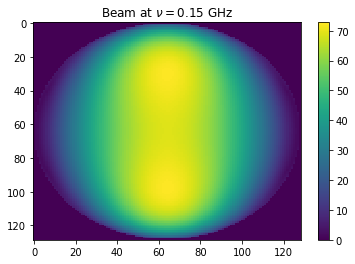

In [65]:
# beam vs phi and theta (data coordinates, extent is [pi/2, 3pi/2, 0, pi])
plot_indx = 100
plt.figure()
uvtools.plot.waterfall(beams[plot_indx], mode='real')
plt.title(r'Beam at $\nu={}$ GHz'.format(freqs_beam[plot_indx]))
plt.colorbar()
plt.show()

In [66]:
freqs = freqs_models[(freqs_beam.max() >= freqs_models) & (freqs_models >= freqs_beam.min())]
beams = interp1d(freqs_beam, beams, axis=0)(freqs)

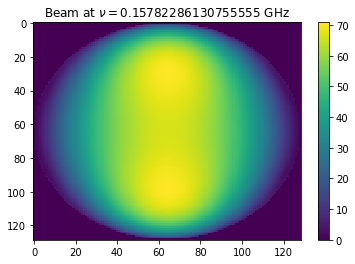

In [71]:
# interpolated beam vs phi and theta (data coordinates, extent is [pi/2, 3pi/2, 0, pi])
plot_indx = -3
plt.figure()
uvtools.plot.waterfall(beams[plot_indx], mode='real')
plt.title(r'Beam at $\nu={}$ GHz'.format(freqs[plot_indx]))
plt.colorbar()
plt.show()

### Dish Beam

In [72]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs_dish = np.array([float(f.split('=')[1].split(')')[0]) for f in beamfiles_dish]) / 1000 # GHz
thetas_dish, phis_dish = np.loadtxt(beamfiles_dish[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas_dish = np.deg2rad(np.unique(thetas_dish))
phis_dish = np.deg2rad(np.unique(phis_dish))
data_dish = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles_dish])
data_dish.shape = (-1, phis_dish.size, thetas.size)

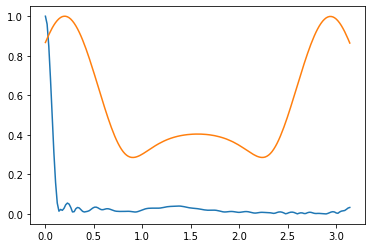

In [73]:
plt.figure()
plt.plot(thetas_dish, data_dish[-1,0,:]/data_dish[-1,0,:].max())
plt.plot(thetas, data[-1,0,:]/data[-1,0,:].max())

In [74]:
NPIX = 129
LD = np.linspace(-1, 1, NPIX,endpoint=True)
MD = np.linspace(-1, 1, NPIX,endpoint=True)
LD.shape = (-1, 1)
MD.shape = ( 1,-1)
LD = LD * np.ones_like(MD)
MD = MD * np.ones_like(LD)
LMD = LD**2 + MD**2
ND = np.where(LMD < 1, np.sqrt(1 - LMD), 0)
th_d = np.arcsin(LMD**.5).flatten()
ph_d = np.arctan2(MD, ND).flatten() - np.pi
ph_d = np.where(ph_d < 0, 2*np.pi+ph_d, ph_d)

/tmp/ipykernel_101/3738840273.py:9: RuntimeWarning: invalid value encountered in sqrt
  ND = np.where(LMD < 1, np.sqrt(1 - LMD), 0)
/tmp/ipykernel_101/3738840273.py:10: RuntimeWarning: invalid value encountered in arcsin
  th_d = np.arcsin(LMD**.5).flatten()


In [75]:
maskd = np.where(LMD < 1, 1, 0)
beams_dish = np.array([RectBivariateSpline(phis_dish, thetas_dish, d)(ph_d, th_d, grid=False)**2 for d in data_dish])
beams_dish.shape = (-1, NPIX, NPIX)
beams_dish *= maskd

In [81]:
beams_dish[~np.isfinite(beams_dish)] = 0.  # set infinite values to 0

In [83]:
beams_dish = interp1d(freqs_dish, beams_dish, axis=0)(freqs)

/tmp/ipykernel_101/613525015.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(beams_dish[-3] / beams_dish[-3].max()))


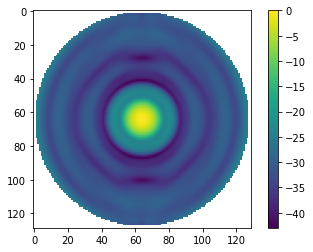

In [85]:
plt.figure()
plt.imshow(10*np.log10(beams_dish[-3] / beams_dish[-3].max()))
plt.colorbar()
#plt.savefig('plots/dish_beam.png',bbox_inches='tight')

/tmp/ipykernel_101/1762316762.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(beams[-3] / beams[-3].max()))


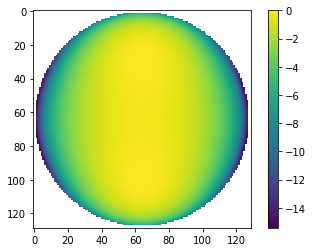

In [86]:
plt.figure()
plt.imshow(10*np.log10(beams[-3] / beams[-3].max()))
plt.colorbar()
#plt.savefig('plots/feed_beam.png',bbox_inches='tight')

## Load GSM

In [131]:
NSIDE = 64
hpb = aipy.healpix.HealpixBase(nside=NSIDE)
I_sky = np.empty((freqs.size, hpb.npix()))
gsm = GlobalSkyModel(freq_unit='GHz')
ga2eq = aipy.coord.convert_m('ga', 'eq')
for ch,f in enumerate(freqs):
    if NSIDE == 512:
        I_sky[ch] = gsm.generate(f)
    else:
        I_sky[ch] = hp.ud_grade(gsm.generate(f), nside_out=NSIDE)

In [132]:
NTIMES = 256
JD = 2459117
jds = np.linspace(JD, JD+1, NTIMES)

crd_eq = np.array(hpb.px2crd(np.arange(hpb.npix())))
antpos = np.array([[0.,0,0]]) # meters
loc = ('40:00', '0:00')
aa = aipy.amp.AntennaArray(loc, antpos)

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(np.dot(aa.eq2top_m, ga2eq))
eq2tops = np.array(eq2tops)

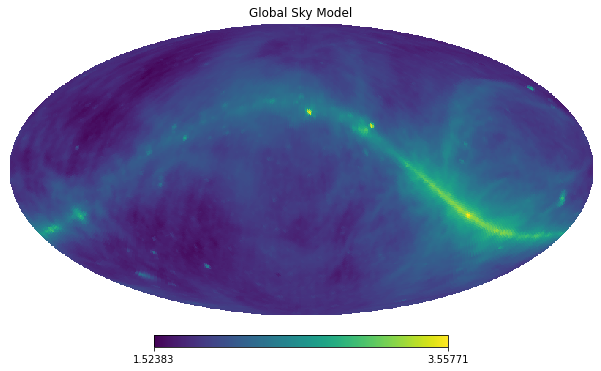

In [133]:
rot=hp.Rotator(coord=['G','C'])
hp.mollview(np.log10(rot.rotate_map_pixel(I_sky[-1])), rot=[0,30,0], title='Global Sky Model')
#plt.savefig('plots/gsm.png', bbox_inches='tight')

/home/christian/anaconda3/lib/python3.8/site-packages/uvtools/plot.py:41: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


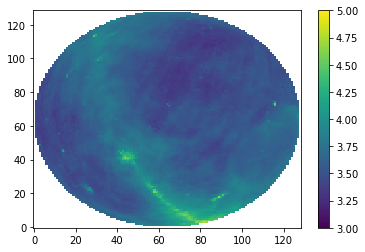

In [134]:
hpm = aipy.healpix.HealpixMap(nside=NSIDE)
hpm.map = I_sky[0]
top = (M.flatten(), L.flatten(), N.flatten())
gx,gy,gz = np.dot(np.linalg.inv(np.dot(eq2tops[150], ga2eq)), top)
img = hpm[gx,gy,gz]
img.shape = (NPIX,NPIX)
plt.figure()
uvtools.plot.waterfall(mask * img, mode='log', mx=5, drng=2, origin='lower')
_ = plt.colorbar()

In [136]:
if not os.path.exists('auto.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams[ch:ch+1])[:,0,0]
    np.savez('auto.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto.npz')
    data = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [137]:
if not os.path.exists('auto_dish.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data_dish = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data_dish[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams_dish[ch:ch+1])[:,0,0]
    np.savez('auto_dish.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto_dish.npz')
    data_dish = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [142]:
gain = beams[:,NPIX//2+1,NPIX//2+1]
avg = np.mean(data[-50:], axis=0) / gain
cal = 180 / avg[np.argmin(np.abs(freqs-0.180))]


gain_dish = beams_dish[:,NPIX//2+1, NPIX//2+1]
avg_dish = np.mean(data_dish[-50:], axis=0) / gain_dish
cal_dish = 180 / avg_dish[np.argmin(np.abs(freqs-0.180))]

/home/christian/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/christian/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


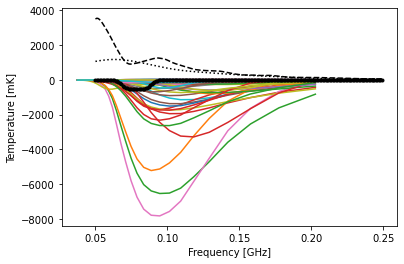

In [145]:
def gen_eor(A, nu0, w, tau):
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

prms = {
    'A': 0.52,
    'nu0': 78.3e-3,
    'w': 20.7e-3,
    'tau': 6.5,
}
fake_eor = gen_eor(**prms)

idata_dish = cal_dish * data_dish / gain_dish + fake_eor
idata = cal * data / gain + fake_eor

plt.figure()

for mdl in models:
    plt.plot(freqs_sampled, 1e3*mdl)
plt.plot(freqs, 1e3*fake_eor, 'k.-')
plt.plot(freqs, idata[0], 'k:')
plt.plot(freqs, idata_dish[0], 'k--')

plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [mK]')
plt.show()

## Make delay plot

In [146]:
import scipy.signal as signal

(1e-05, 1.0)

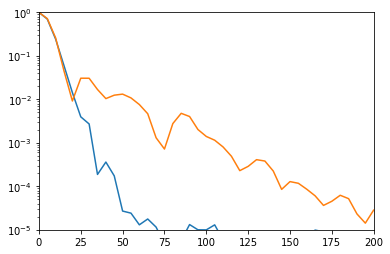

In [147]:
bh = signal.blackmanharris(200)
bh /= bh.mean()
beam_fft = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * beams[:, 65, 65].squeeze())))
beam_dish_fft = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * beams_dish[:, 65, 65].squeeze())))

dlys = np.fft.fftshift(np.fft.fftfreq(200, np.mean(np.diff(freqs))))
plt.figure()
plt.plot(dlys, np.abs(beam_fft / beam_fft.max()))
plt.plot(dlys, np.abs(beam_dish_fft / beam_dish_fft.max()))
plt.xlim(0,200)
plt.yscale('log')
plt.ylim(1e-5, 1e0)

In [148]:
def dayenu(dat, width=1.):
    _, rdat, _ = uvtools.dspec.fourier_filter(
                                x=freqs * 1e9,
                                data=dat,
                                wgts=np.ones_like(dat),
                                mode='dpss_leastsq',
                                filter_centers=[0.],
                                filter_half_widths=[width * 1e-9],
                                eigenval_cutoff=[1e-12],
                                suppression_factors=[1e-9]
    )
    return rdat

rdata = dayenu(data / data[55]) * data[55]

In [149]:
#def dayenu(data):
#    return data

#idata = cal * data / gain + fake_eor

tint = 3600. * 50. 
DF = np.mean(np.diff(freqs))
noise = idata * np.random.randn(*idata.shape) / np.sqrt(DF * 1e9 * tint)
noise_d = idata_dish * np.random.randn(*idata_dish.shape) / np.sqrt(DF * 1e9 * tint)

# Build a filter to exclude EoR from calibration signal
d = idata - np.mean(idata[-50:], axis=0)
dd = idata_dish - np.mean(idata_dish[-50:], axis=0)

C = np.dot(d.T, d)
Cd = np.dot(dd.T, dd)
U,S,V = np.linalg.svd(C)
Ud,Sd,Vd = np.linalg.svd(Cd)

#plt.figure(); plt.plot(S)
iS = np.identity(S.size)

#iS[10:,10:] = 0
iS[5:,5:] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))

Cinvd = np.dot(Vd.T, np.dot(iS, Ud.T))

#pcal = idata[55] - 0.5 * fake_eor # XXX
pcal = np.dot(Cinv, idata[55]) # filter to exclude most of eor signal
pcald = np.dot(Cinvd, idata_dish[55]) # filter to exclude most of eor signal

reor = dayenu(fake_eor / pcal) * pcal
rmodels = dayenu(models / pcal) * pcal

reord = dayenu(fake_eor / pcald) * pcald
rmodelsd = dayenu(models / pcald) * pcald


idata_flattened = dayenu(idata / pcal) * pcal
idata_flattened_dish = dayenu(idata_dish / pcald) * pcald

noise_flattened = dayenu(noise / pcal) * pcal
noise_flattened_dish = dayenu(noise / pcald) * pcald

ValueError: operands could not be broadcast together with shapes (100,32) (200,) 

In [ ]:
plt.figure()
for mdl in rmodels:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*reor, 'k.-')
plt.plot(freqs, idata_flattened[0], 'k:')

In [ ]:
d = idata_flattened - np.mean(idata_flattened[-50:], axis=0)
C = np.dot(d.T, d)
U,S,V = np.linalg.svd(C)



dd = idata_flattened_dish - np.mean(idata_flattened_dish[-50:], axis=0)
Cd = np.dot(dd.T, dd)
Ud,Sd,Vd = np.linalg.svd(Cd)

In [ ]:
du = idata - np.mean(idata[-50:], axis=0)
Cu = np.dot(du.T, du)
Uu, Su, Vu = np.linalg.svd(Cu)

In [ ]:
dud = idata_dish - np.mean(idata_dish[-50:], axis=0)
Cud = np.dot(dud.T, dud)
Uud, Sud, Vud = np.linalg.svd(Cud)

In [ ]:
m = rmodels - np.mean(rmodels, axis=0)
Cm = np.dot(m.T, m)
Um, Sm, Vm = np.linalg.svd(Cm)

In [ ]:
m = rmodelsd - np.mean(rmodelsd, axis=0)
Cmd = np.dot(m.T, m)
Umd, Smd, Vmd = np.linalg.svd(Cmd)

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata_flattened, mode='real')
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Vm, idata_flattened.T).T, mode='log')
_ = plt.colorbar()

In [ ]:
plt.figure()
print(rmodels.shape)
#plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
plt.semilogy(np.abs(np.dot(V, reor)),'r')
#plt.semilogy(S, 'k.-')
plt.semilogy(np.abs(np.dot(V, (idata_flattened[55:] - reor).T)), 'k:')
#plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
plt.grid()
plt.xlim(0,50)

In [ ]:
plt.figure()
print(rmodels.shape)
#plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
plt.semilogy(np.abs(np.dot(Vd, reord)),'r')
#plt.semilogy(S, 'k.-')
plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[55:] - reord).T)), 'k:')
#plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
plt.grid()
plt.xlim(0,50)

In [ ]:
dot_matrix = np.zeros((len(freqs), len(freqs)))
dot_matrix_d = np.zeros_like(dot_matrix)
for i in range(dot_matrix.shape[0]):
    for j in range(dot_matrix.shape[1]):
        dot_matrix[i, j] = Vm[i] @ V[j] * np.sqrt( Sm[i])
        dot_matrix_d[i, j] = Vm[i] @ Vd[j] * np.sqrt(Smd[i])

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.1, .4-h_gap/2, .8]), fig.add_axes([.4+.1, 0.1, .4-h_gap/2, .8])]


plt.sca(axarr[0])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::10], lw=1, alpha=.1, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reord).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
plt.semilogy(x, 'k-', lw=4)
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
plt.axhline(np.mean(np.abs(np.dot(Vd, (noise_flattened[np.argmin(np.mean(idata_flattened, axis=1))]).T))),
             ls='--', color='green', lw=4)
#index_tm4 = np.argmin(np.dot(V, ))
#plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
#plt.gca().set_xticklabels([])
plt.gca().tick_params(labelsize=16)
plt.ylim(1e-3, 1e4)
plt.xlim(0,55)
plt.xlabel('Eigenvector Number', fontsize=18)
plt.ylabel('Component Amplitude [K]', fontsize=18)




plt.sca(axarr[1])
#plt.semilogy(np.abs(np.dot(Vd, )))
l3=plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T))[:, ::10], lw=1, alpha=.1, color='grey')[0]
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()

l0=plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k-', lw=4)[0]
l1=plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='--')[0]
l2=plt.axhline(np.mean(np.abs(np.dot(Vd, (noise_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))]).T))),
             color='green', ls='--', lw=4)

plt.legend((l0, l1, l2, l3), ('Foregrounds and Beam', 'EDGES', 'Thermal Noise', '21cm Models'))
plt.grid()
plt.gca().tick_params(labelsize=16)
#plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 1e4)
plt.xlim(0,55)
plt.gca().set_yticklabels([])
#plt.gca().set_xticklabels([])
plt.xlabel('Eigenvector Number', fontsize=18)

threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()



plt.gcf().set_size_inches(14, 7)




#plt.savefig('pc_plot.png', bbox_inches='tight')

In [ ]:
plt.figure()
bh = signal.blackmanharris(len(freqs))
x=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)))
y=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)))
#x[dlys>=125] = 0
dlys = fft.fftshift(fft.fftfreq(len(bh), np.mean(np.diff(freqs))))
l0=plt.plot(dlys, np.abs(y), color='k', label='14 meter Dish', lw=4)[0]
l1=plt.plot(dlys, np.abs(x), color='r', label='Vivaldi Antenna',lw=4)[0]
l2=plt.plot(dlys, np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * reor)))), label='EDGES', color='orange',lw=4)[0]
l3=plt.plot(dlys, np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh[None,:] * rmodels, axes=1), axis=1), axes=1)).T, color='grey', lw=1, alpha=0.1)[0]
plt.legend([l0, l1, l2, l3], ['14 meter dish', 'Vivaldi', 'EDGES', '21cm models'], loc='best', fontsize=18)
plt.yscale('log')
plt.xlim(0, 300)
plt.ylim(1e-4,5e1)
plt.grid()
plt.xlabel('$\\tau$ [ns]', fontsize=18)
plt.ylabel('Spectrum Fourier Transform [K]', fontsize=18)
plt.gca().tick_params(labelsize=16)
plt.gcf().set_size_inches(8,7)
#plt.savefig('plots/delay_transform_plot.png', bbox_inches='tight')

In [ ]:
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.1, .35-h_gap/2, .5]), fig.add_axes([0.45, 0.1, .35-h_gap/2, .5]),
       fig.add_axes([0.8, 0.1, 0.2-h_gap/2, .5])]
axarr = [[fig.add_axes([0.1, 0.6+h_gap/2, .35-h_gap/2, .25]),
          fig.add_axes([0.45, 0.6+h_gap/2, .35-h_gap/2, .25])],
          axarr]




plt.sca(axarr[0][0])
plt.semilogy(np.abs(np.dot(V, rmodels.T)), lw=1, alpha=.05, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reord).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
plt.semilogy(x, 'k-', lw=4)
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
#index_tm4 = np.argmin(np.dot(V, ))
plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
plt.gca().set_xticklabels([])


plt.ylim(1e-3, 1e4)
plt.xlim(0,30)

plt.sca(axarr[0][1])
#plt.semilogy(np.abs(np.dot(Vd, )))
plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T)), lw=1, alpha=.05, color='grey')
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()

plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k--', lw=4)
plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='--')

plt.grid()
plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 1e4)
plt.xlim(0,30)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])


threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()

plt.sca(axarr[1][2])
plt.semilogx(np.sqrt(np.abs(Vm @ rmodels.T)), np.arange(len(freqs)),lw=1, color='grey', ls = '-', alpha=0.05)

plt.semilogx(np.sqrt(np.abs(Sm)), np.arange(len(freqs)),lw=4, color='grey', ls = '--')
plt.semilogx(np.abs(np.dot(Vm, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)),
                                np.arange(len(freqs)), lw=4, ls='-', color='k')
plt.semilogx(np.abs(np.dot(Vm, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
                                np.arange(len(freqs)), lw=4, ls='--', color='k')
plt.semilogx(np.abs(np.dot(Vm, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
                                np.arange(len(freqs)), lw=4, ls='--', color='k')
plt.semilogx(np.abs(np.dot(Vm, reor)), np.arange(len(freqs)), ls='--', color='orange', lw=4)
plt.axhline(threshold_21cm, color='orange', ls='--')
plt.axhline(threshold_21cmd, color='orange', ls=':')

plt.ylim(30,0)
plt.grid()
plt.xlim(5e-4, 1e2)
plt.gca().set_yticklabels([])


plt.sca(axarr[1][0])
plt.imshow(np.abs(dot_matrix), cmap='Greys', interpolation='nearest', aspect='auto', norm=colors.LogNorm(1e-1,1e1))
#plt.colorbar()
plt.xlim(0, 30)
plt.ylim(30, 0)
# find 99.9 percent eigenval for foregrounds
plt.axvline(threshold_fg, color='r', ls='--')
plt.axhline(threshold_21cm, color='orange', ls='--')



plt.sca(axarr[1][1])
plt.imshow(np.abs(dot_matrix_d),  cmap='Greys', interpolation='nearest', aspect='auto', norm=colors.LogNorm(1e-1,1e1))
#plt.colorbar()
plt.xlim(0, 30)
plt.ylim(30, 0)
plt.axvline(threshold_fg_d, color='r', ls='--')
plt.gcf().set_size_inches(8, 6)
plt.gca().set_yticklabels([])
plt.axhline(threshold_21cmd, color='orange', ls=':')

plt.savefig('pc_dot_plot.png', bbox_inches='tight')

NameError: name 'idata' is not defined

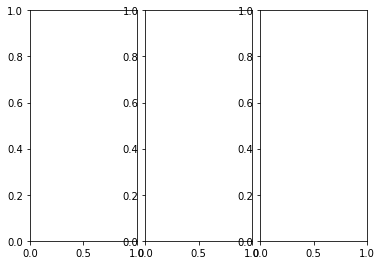

In [20]:
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([.8/3+.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([2*.8/3+.1, 0.2, .8/3-h_gap/2, .8])]

plt.sca(axarr[0])
#plt.text(85, 0.6, '$\\times 10^{-3}$', color='k', fontsize=14)
#plt.text(55, 0.23, '$\\times 10^{-3}$', color='r', fontsize=14)

l0=plt.plot(freqs * 1e3, np.abs(idata[::50] - reor).T/1e4, color='r', lw=1, ls='-')[0]
l1=plt.plot(freqs * 1e3, np.abs(idata_dish[::50] - reord).T/1e4, color='k', lw=1, ls='-')[0]

#l2=plt.semilogy(freqs * 1e3, np.abs(idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor), color='r', lw=4)[0]
#l3=plt.semilogy(freqs * 1e3, np.abs(idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor), color='k', lw=4)[0]
l2=plt.plot(freqs * 1e3, models.T[:, ::10], lw=1, alpha=.5, color='grey')[0]
l3=plt.plot(freqs * 1e3, fake_eor, color='orange', lw=4)[0]
l5 = plt.plot(freqs*1e3, models[895], lw=2, color='purple')[0]
#for m in range(3):
    #plt.plot(freqs * 1e3, (Vu[m] @ idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor)*Vu[m] / 1e2, color='r', lw=1)
#    plt.plot(freqs * 1e3, Vu[m]*2, color='r', lw=1)

    
#for m in range(3):
    #plt.plot(freqs * 1e3, (Vud[m] @ idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord)*Vud[m] / 1e2, color='k', lw=1)
#    plt.plot(freqs * 1e3, Vud[m]*2, color='k', lw=1)

    
summed = np.zeros_like(freqs,dtype=complex)
#for m in range(3):
#    summed+=Vu[m] @ (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor)*Vu[m] / 1e4
#plt.plot(freqs*1e3, summed, ls='--', color='r')
    

#l5=plt.semilogy(freqs * 1e3, np.abs(2.73/10+fake_eor), color='orange', ls=':', lw=4)[0]

plt.ylim(-.6, 1)
#l7=plt.plot(freqs * 1e3, np.abs(idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint), color='green', ls='--', lw=4)[0]

plt.ylabel('|T| [K]', fontsize=18)
plt.grid()
#plt.ylim(1e-3, 5e3)
plt.xlim(55, 245)
plt.gca().tick_params(labelsize=16)
plt.xlabel("$\\nu$ [MHz]", fontsize=18)


plt.sca(axarr[2])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::50], lw=1, alpha=.5, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(V.T @ np.diag(np.abs((idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ V))

#plt.semilogy(np.abs(np.dot(Vd, (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)),
#             'r', lw=4)[0]
l0=plt.semilogy(x, 'r-', lw=4)[0]
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
l4=plt.semilogy(noise_level, color='green', ls='--', lw=4)[0]
plt.semilogy(np.abs(V @ rmodels[895]), lw=2, color='purple')

#index_tm4 = np.argmin(np.dot(V, ))
#plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
#plt.gca().set_xticklabels([])
plt.gca().tick_params(labelsize=16)
plt.ylim(1e-3, 5e3)
plt.xlim(0,45)
plt.xlabel('Foreground Eigenmode', fontsize=18)
#plt.gca().set_yticklabels([])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.ylabel('|T| [K]', fontsize=18)



plt.sca(axarr[1])
#plt.semilogy(np.abs(np.dot(Vd, )))
l3=plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T))[:, ::50], lw=1, alpha=.5, color='grey')[0]
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(Vd.T @ np.diag(np.abs((idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ Vd))

#l0=plt.semilogy(np.abs(np.dot(Vd, (idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
#             'k', lw=4)[0]
l1=plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k-', lw=4)[0]
l3=plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='-')[0]
plt.semilogy(np.abs(Vd @ rmodelsd[895]), lw=2, color='purple')
#l2=plt.semilogy(freqs * 1e3, np.abs(Vd @ (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor) / np.sqrt(DF * 1e9 * tint)), color='green', ls='--', lw=4)[0]
plt.semilogy(noise_level, color='green', ls='--', lw=4)


plt.grid()
plt.gca().tick_params(labelsize=16)
#plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 5e3)
plt.xlim(0,45)
#plt.gca().set_xticklabels([])
plt.xlabel('Foreground Eigenmode', fontsize=18)
plt.gca().set_yticklabels([])

threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()



plt.gcf().set_size_inches(14, 6)


fig.legend((l0,l1,l3, l5,l2, l4), ('Vivaldi Foregrounds', 'Dish Foregrounds', 'EDGES 21cm', 'Nominal 21cm', 'Other 21cm', 'Thermal Noise'), loc='lower center' ,ncol=6, fontsize=12)


plt.savefig('plots/pc_plot_w_frequency.png', bbox_inches='tight')